In [1]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import squarify   
import seaborn as sb

In [2]:
scores = pd.read_csv('/home/ahr/Desktop/HTVS/complex/csv/Scores.csv')

In [3]:
# load information
prot='PSC5'
df = pd.read_csv(prot + '.csv')
# get the information of the clusters
cluster = pd.read_csv('/home/ahr/Desktop/Work/MolDescriptors/clusters_csvs/smiles.csv')

In [4]:
# wangle dataframe; data cluster column
# str[5:10] is for reduce id to only ligand name
target = df.dropna(subset=["Unnamed: 0"]) \
           .reset_index() \
           .loc[:, ['id', 'resid', 'interaction']]
target['id'] = target['id'].str[5:10]

# Create an empty 'cluster' column in the df DataFrame
target['cluster'] = None

# Iterate through the 'id' column of the df DataFrame
for i, id_ in enumerate(target['id']):
    # Check if the 'id' is present in the 'compound' column of the cluster DataFrame
    if id_ in cluster['compound'].values:
        # If it is present, get the corresponding cluster value
        cluster_val = cluster.loc[cluster['compound'] == id_, 'cluster'].values[0]
        # Assign the cluster value to the 'cluster' column in the df DataFrame
        target.loc[i, 'cluster'] = cluster_val

In [5]:
## add score values
scores = scores.rename(columns={'Unnamed: 0': 'id'})
scores = scores[['id',str(prot)]]
target = pd.merge(target, scores, on='id')


In [6]:
## save data of PLIP / clusters
## make dfs per cluster
n_clusters = 5

dfs = {i:target.loc[target['cluster'] == i] for i in range(0, n_clusters)}

## save csv
target.to_csv('target_PLIP.csv')
print('All the data is save it on: target_PLIP.csv')

for i in dfs:
    dfs[i].to_csv('clusters_PLIP_'+str(i)+'.csv')
    print('files are save it on: clusters_PLIP_'+str(i)+'.csv')

## save information in cluster df
for i in range(0, n_clusters):
    exec(f"cluster_{i} = dfs[{i}]")

All the data is save it on: target_PLIP.csv
files are save it on: clusters_PLIP_0.csv
files are save it on: clusters_PLIP_1.csv
files are save it on: clusters_PLIP_2.csv
files are save it on: clusters_PLIP_3.csv
files are save it on: clusters_PLIP_4.csv


cluster_0 has 38 elements 


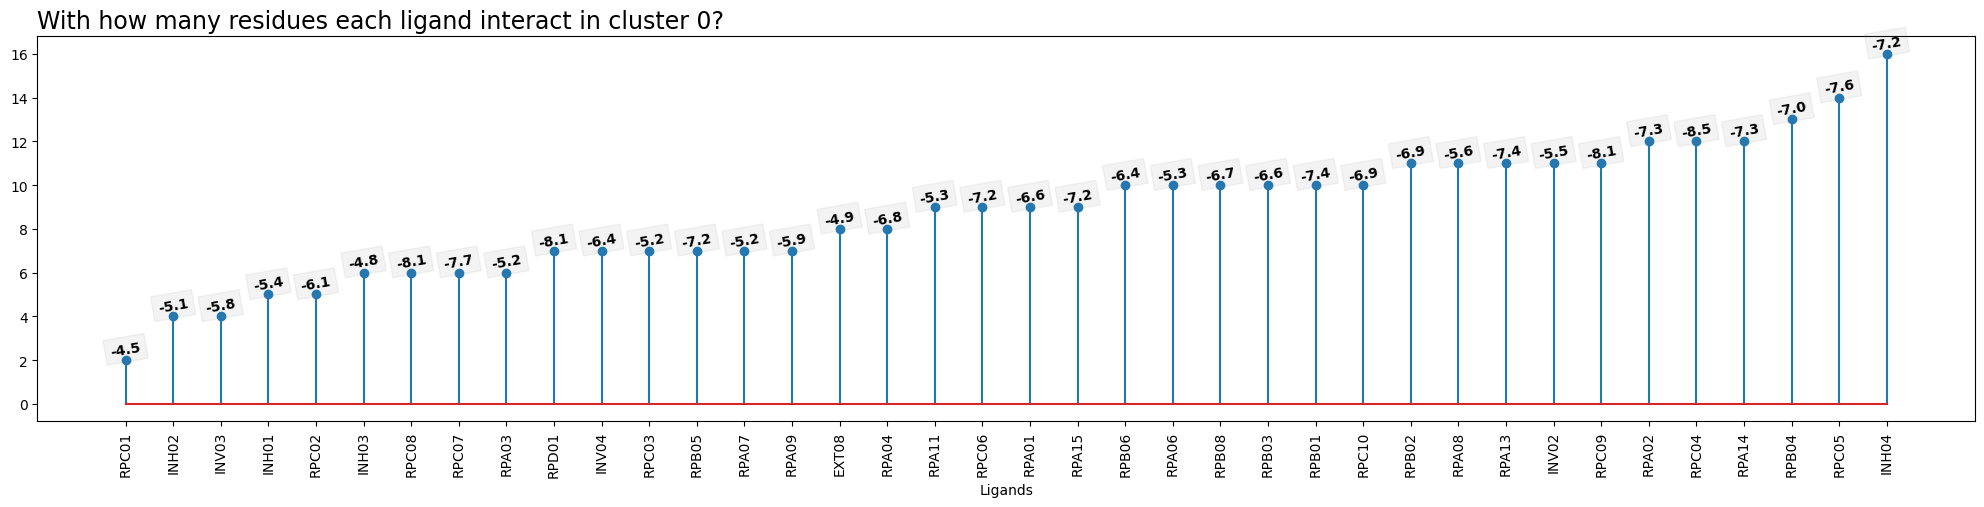

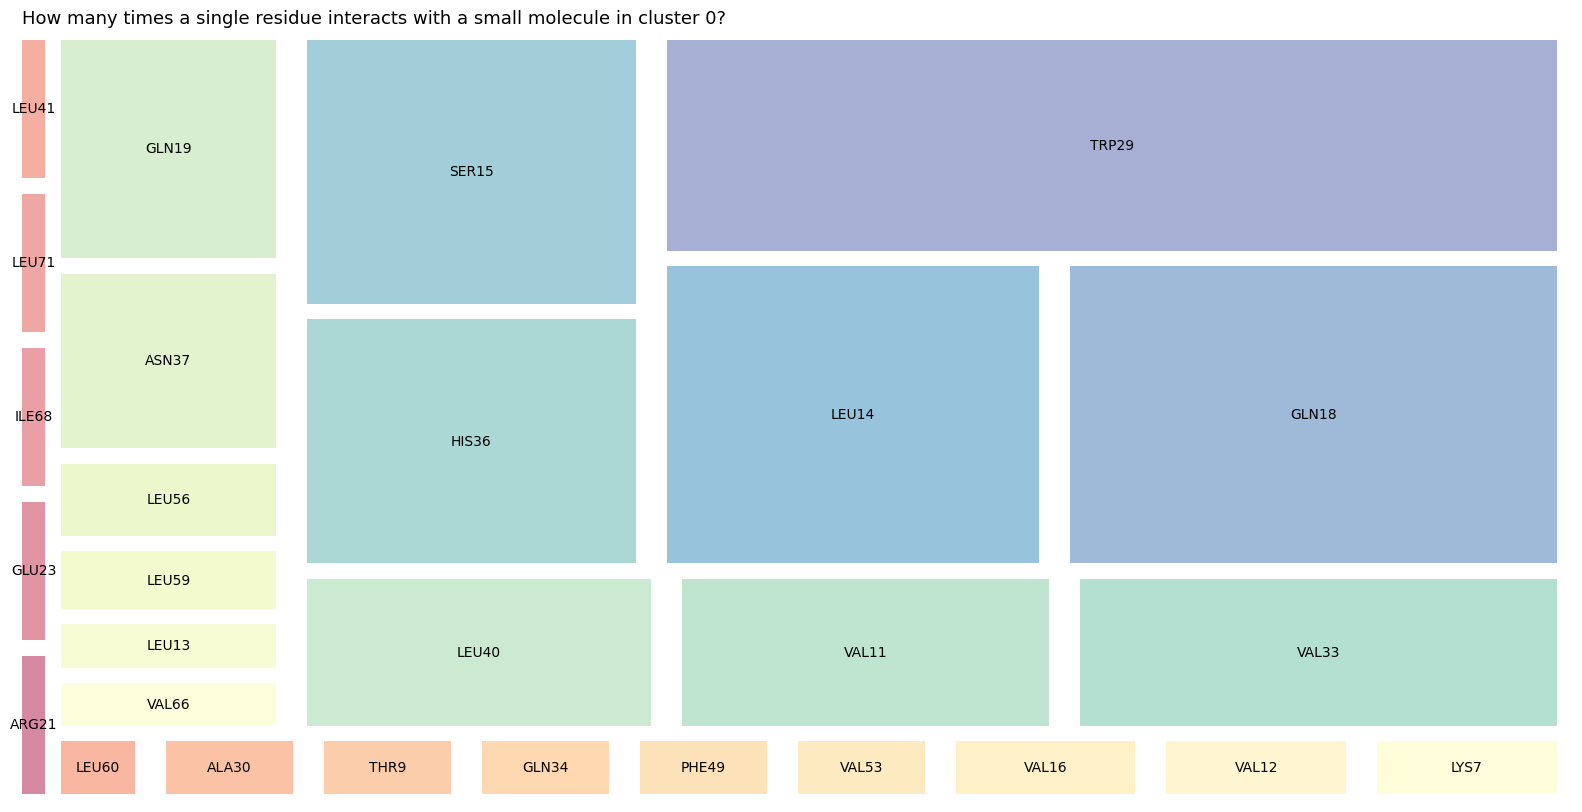

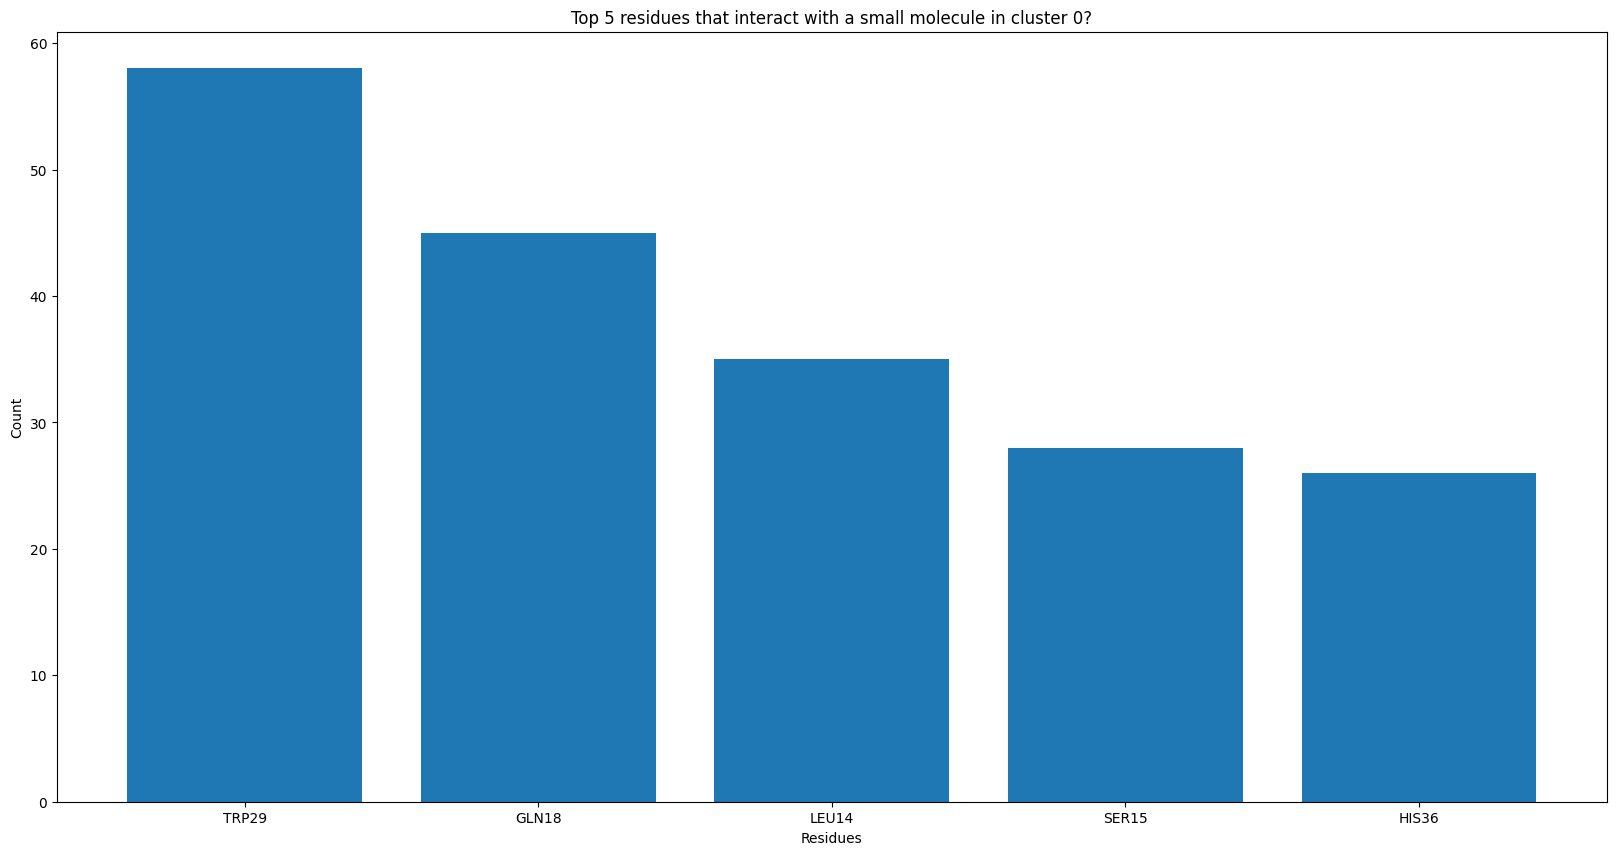

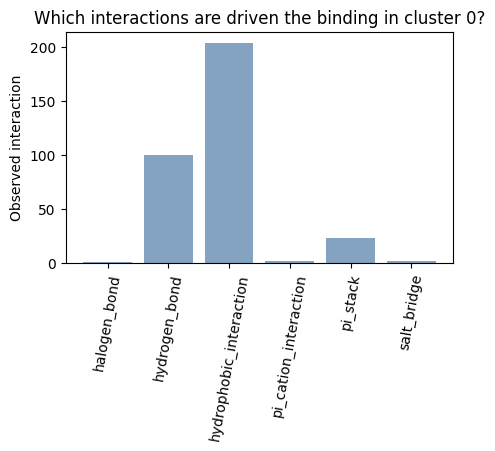

cluster_1 has 17 elements 


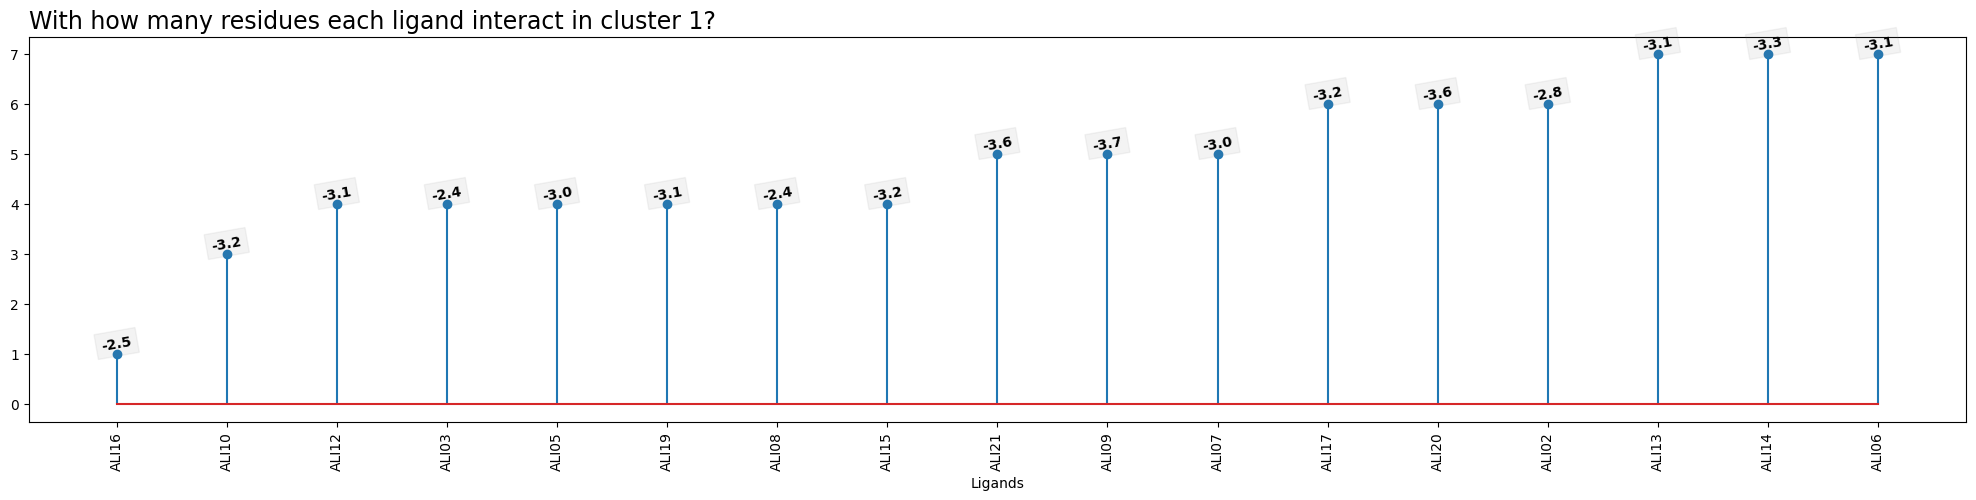

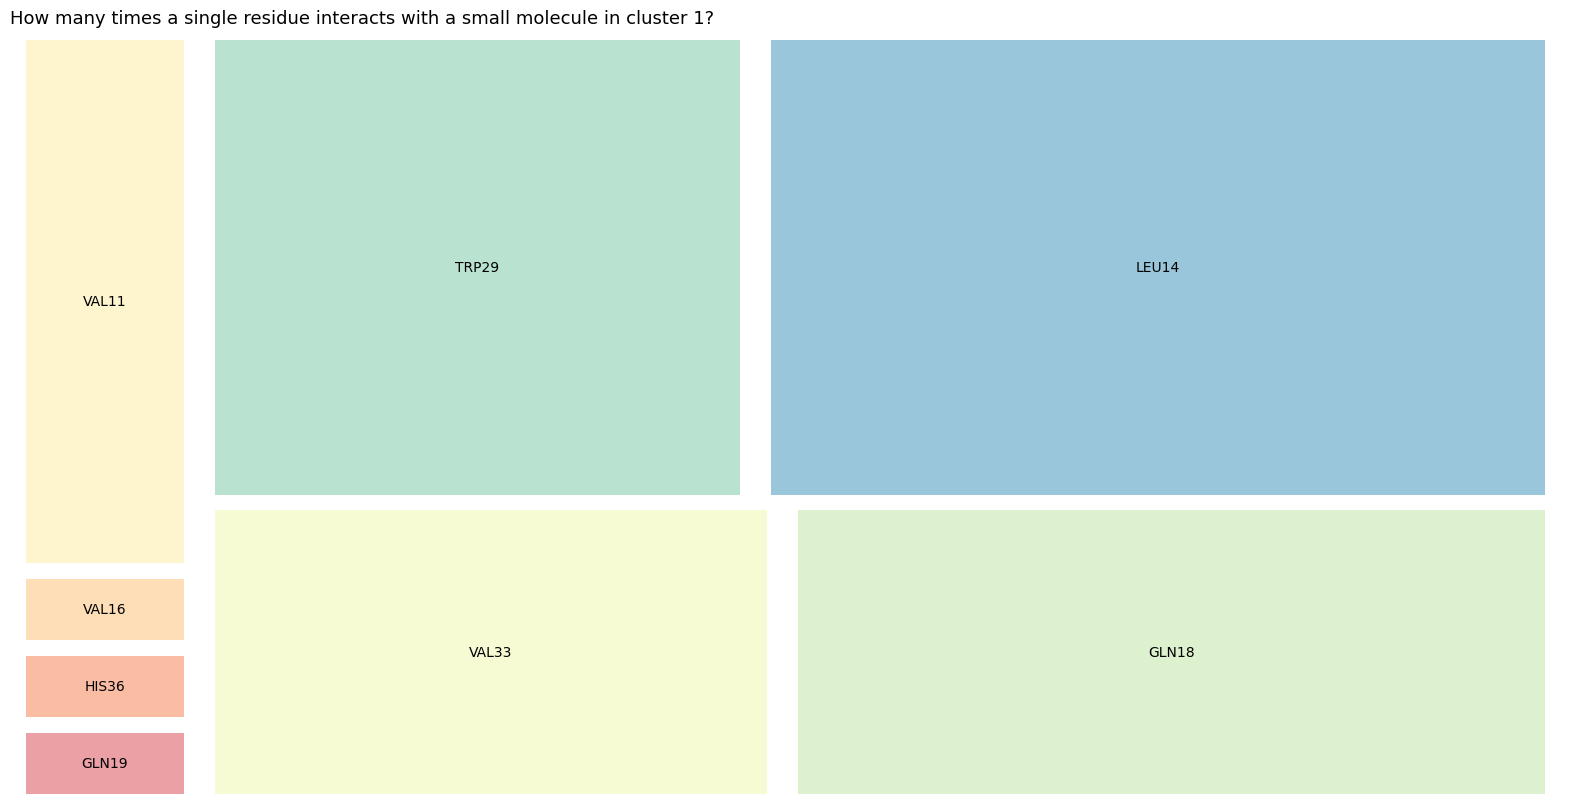

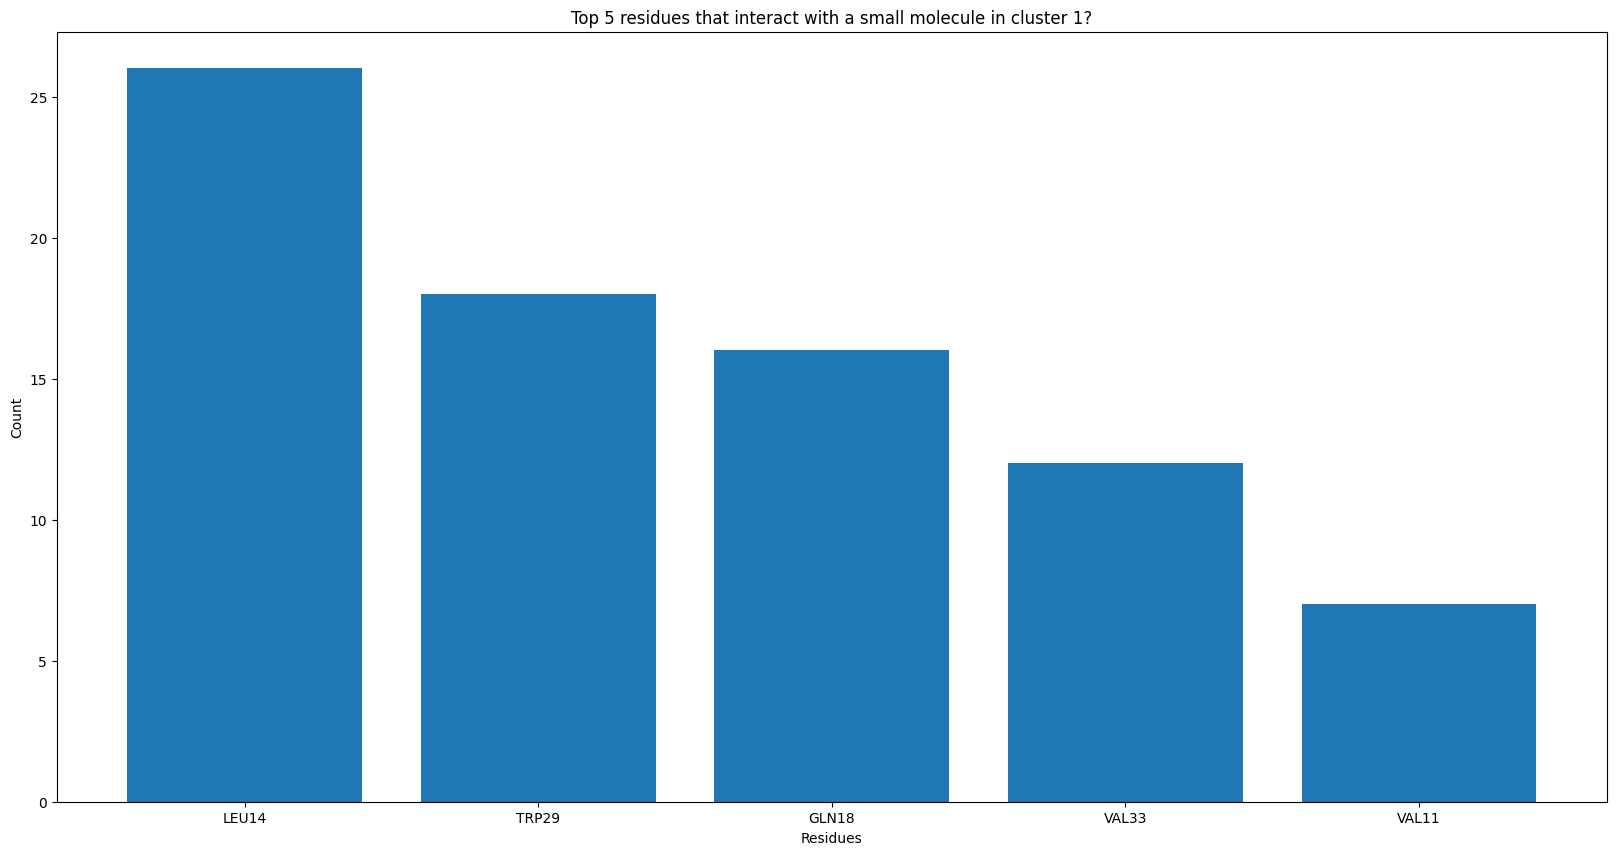

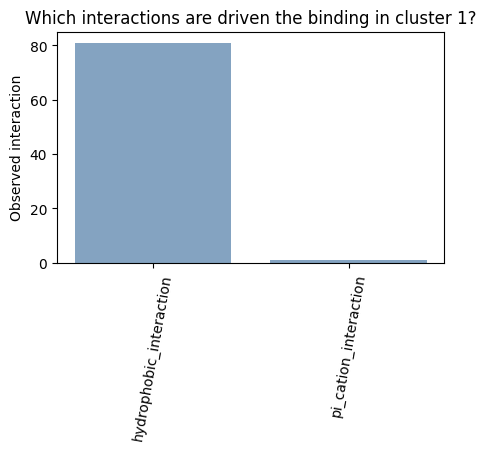

cluster_2 has 13 elements 


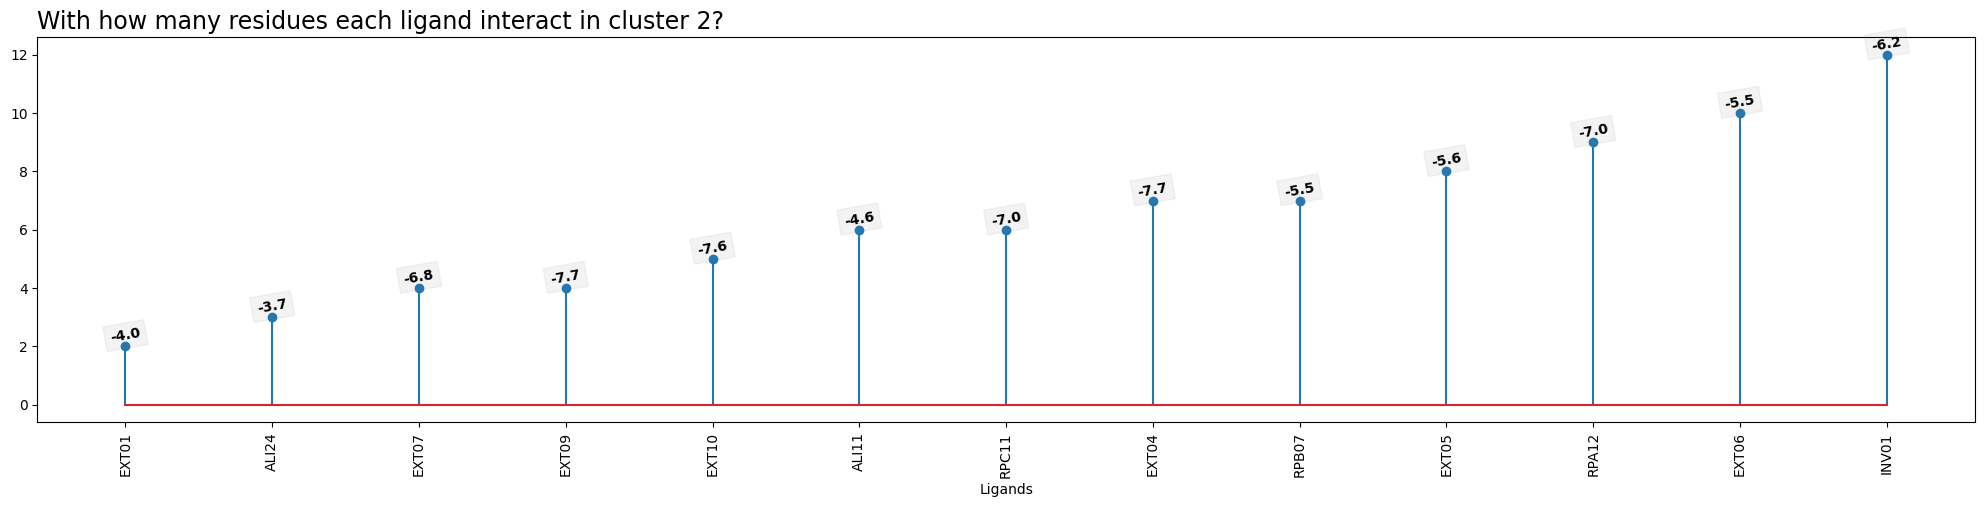

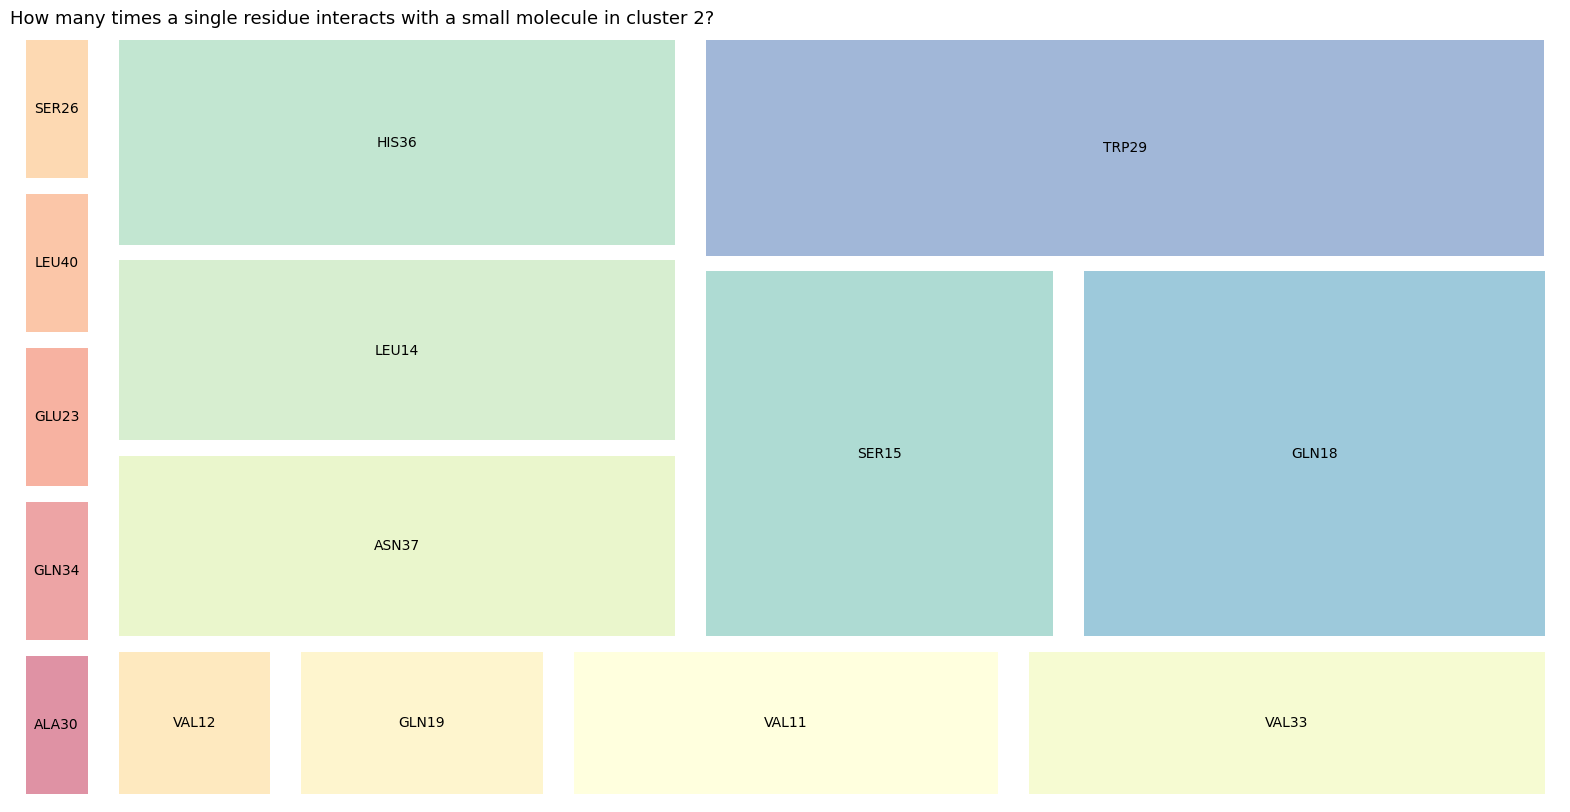

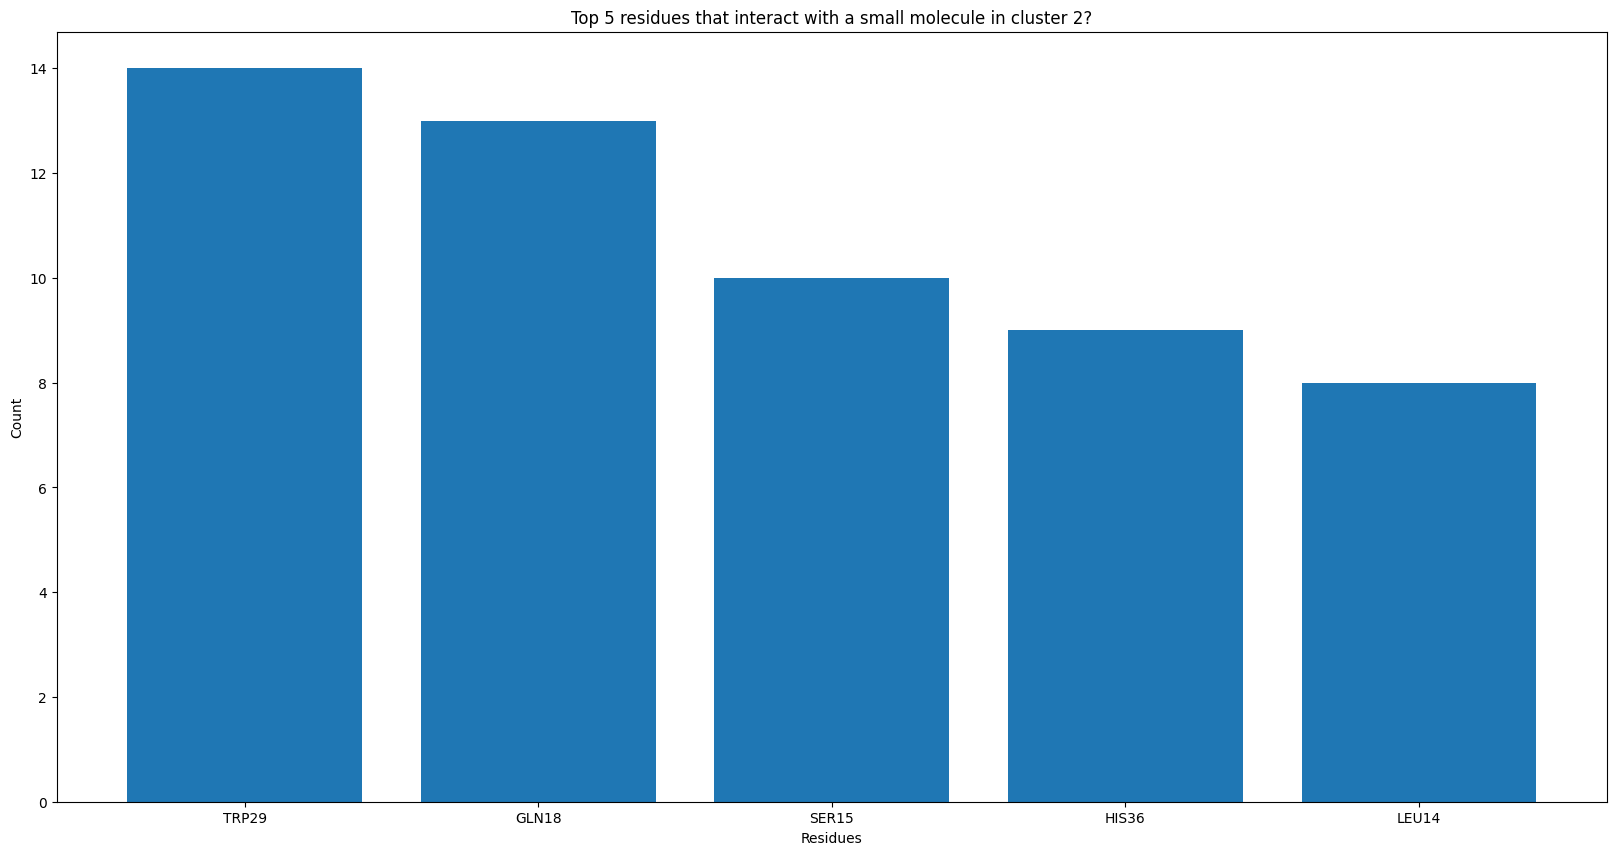

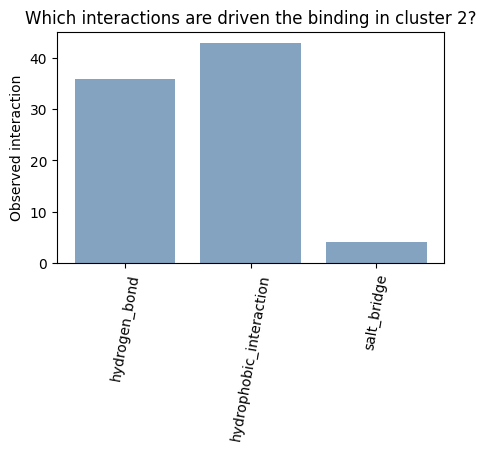

cluster_3 has 7 elements 


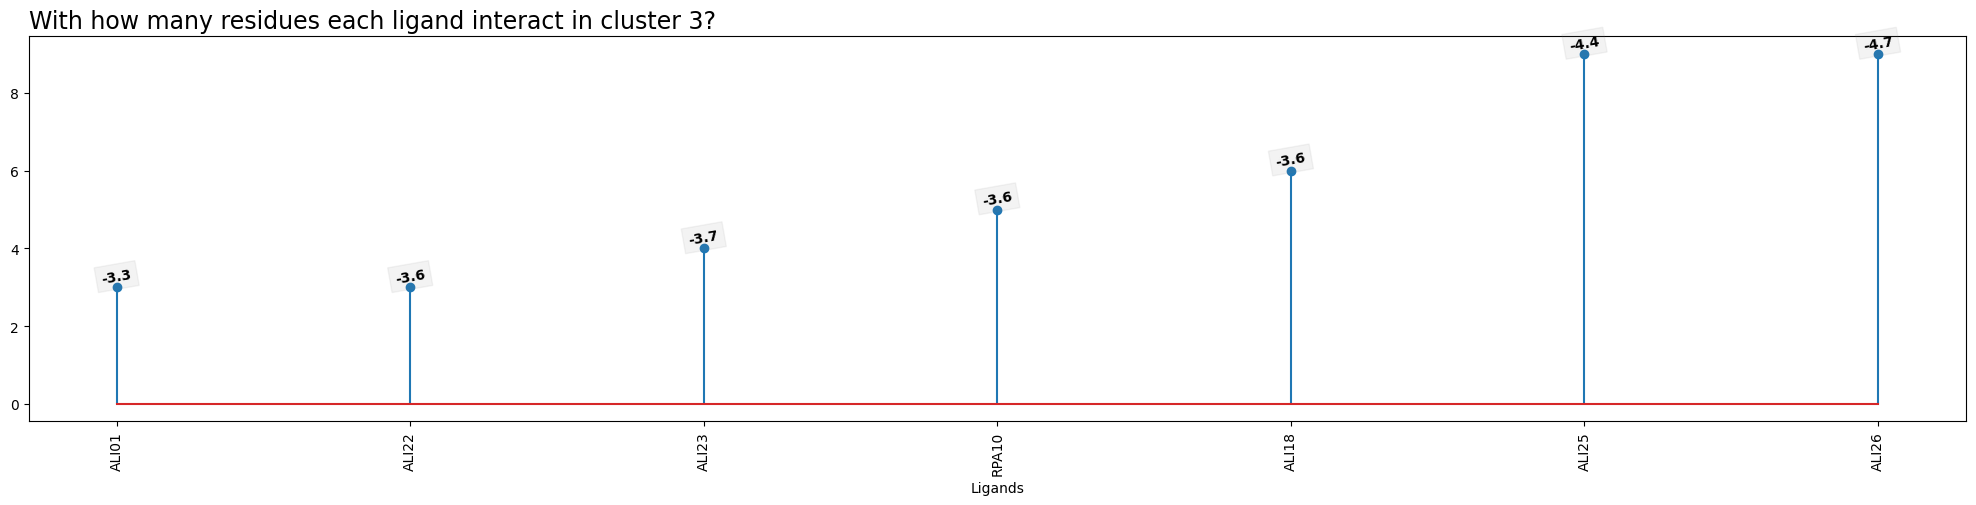

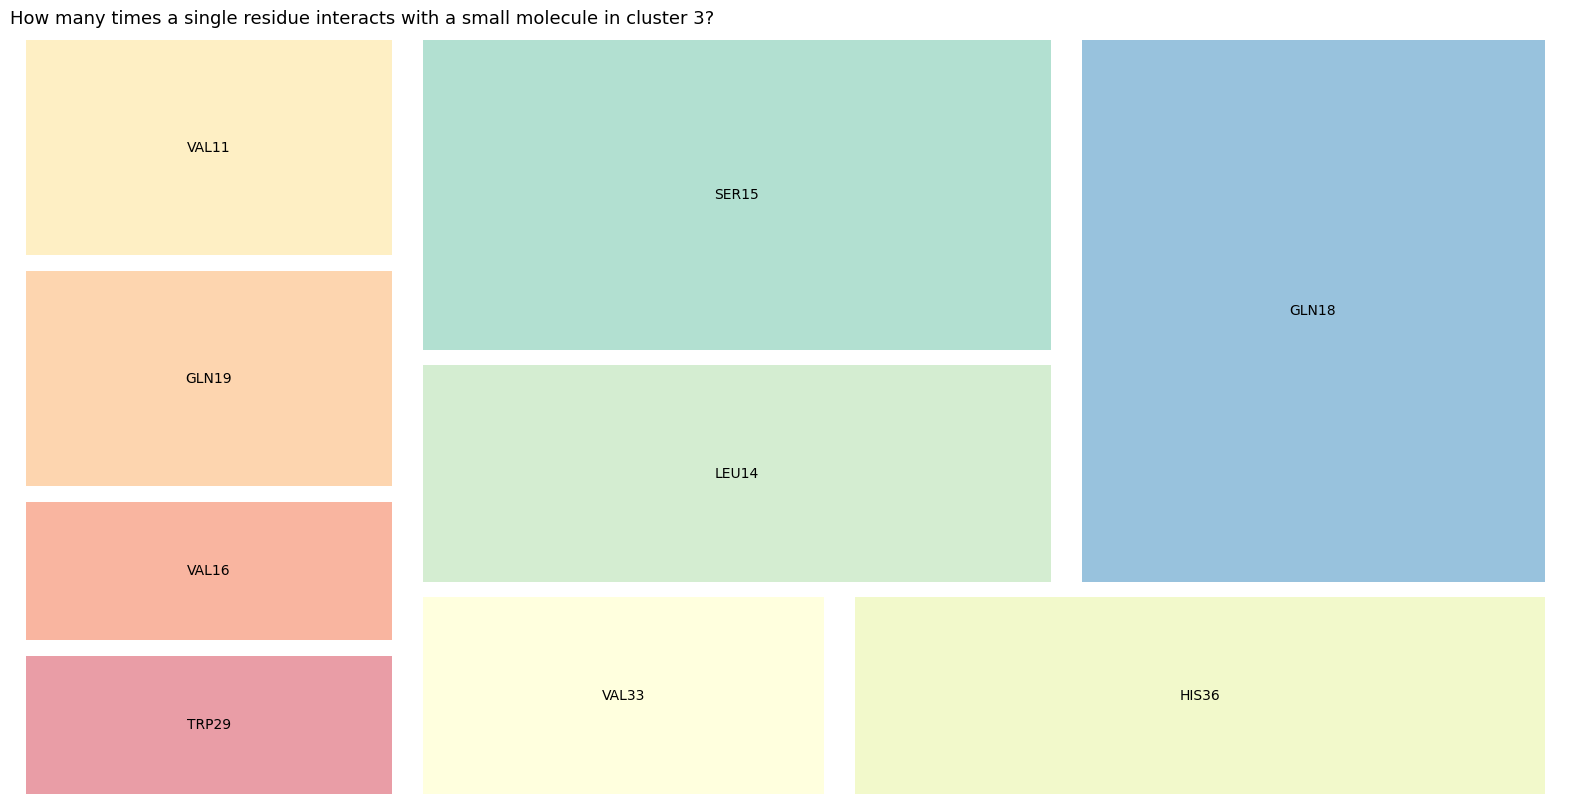

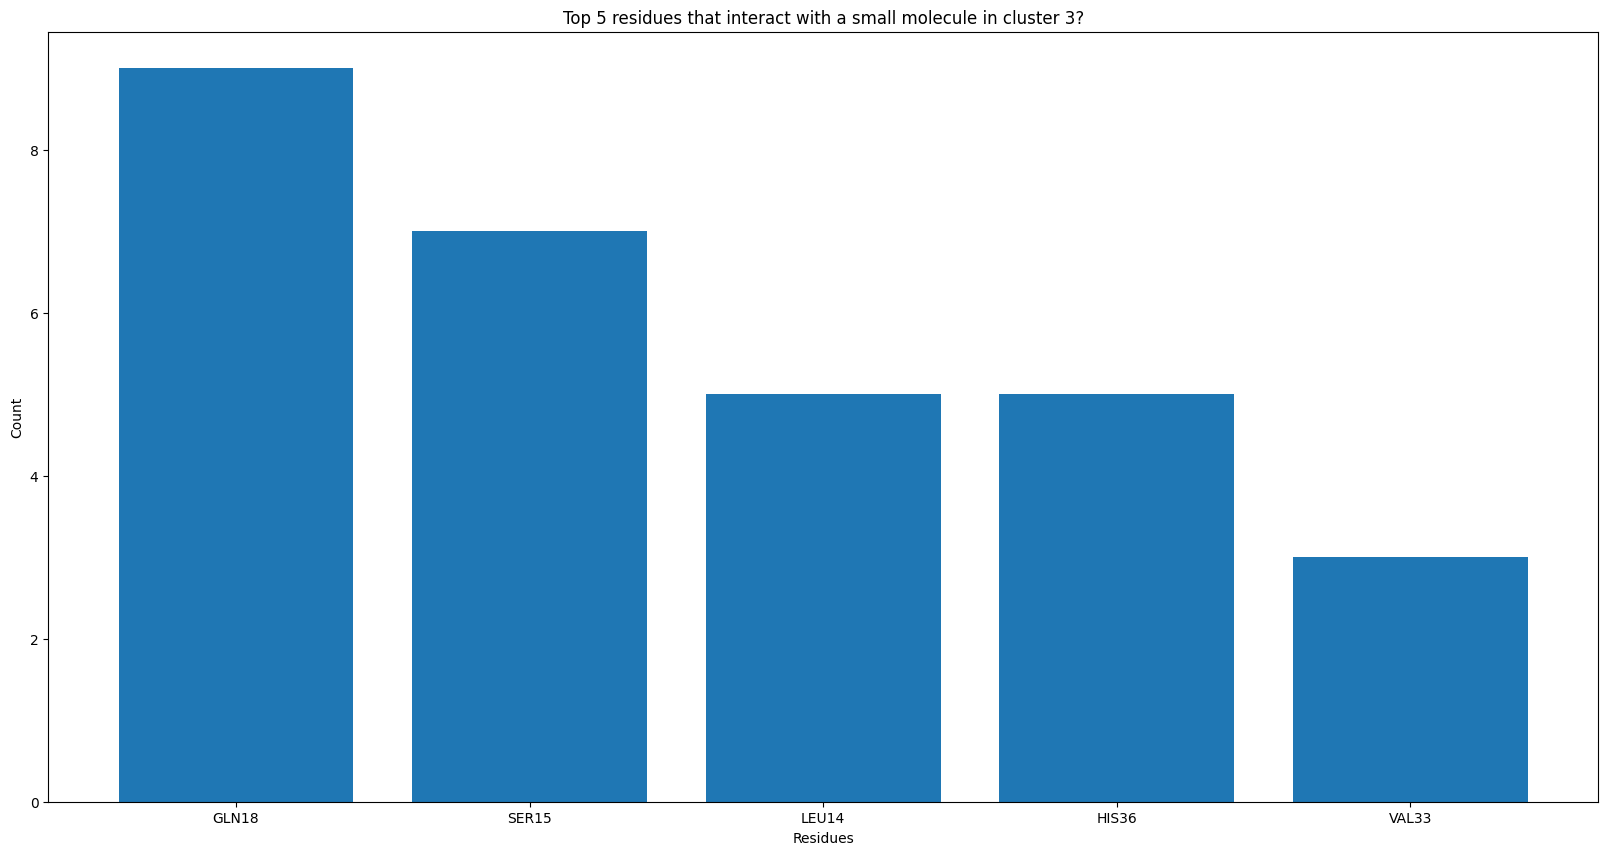

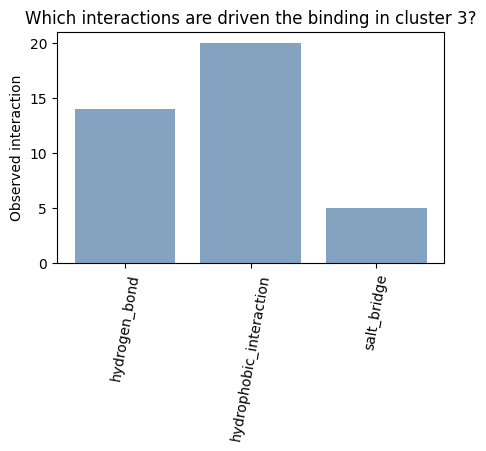

cluster_4 has 5 elements 


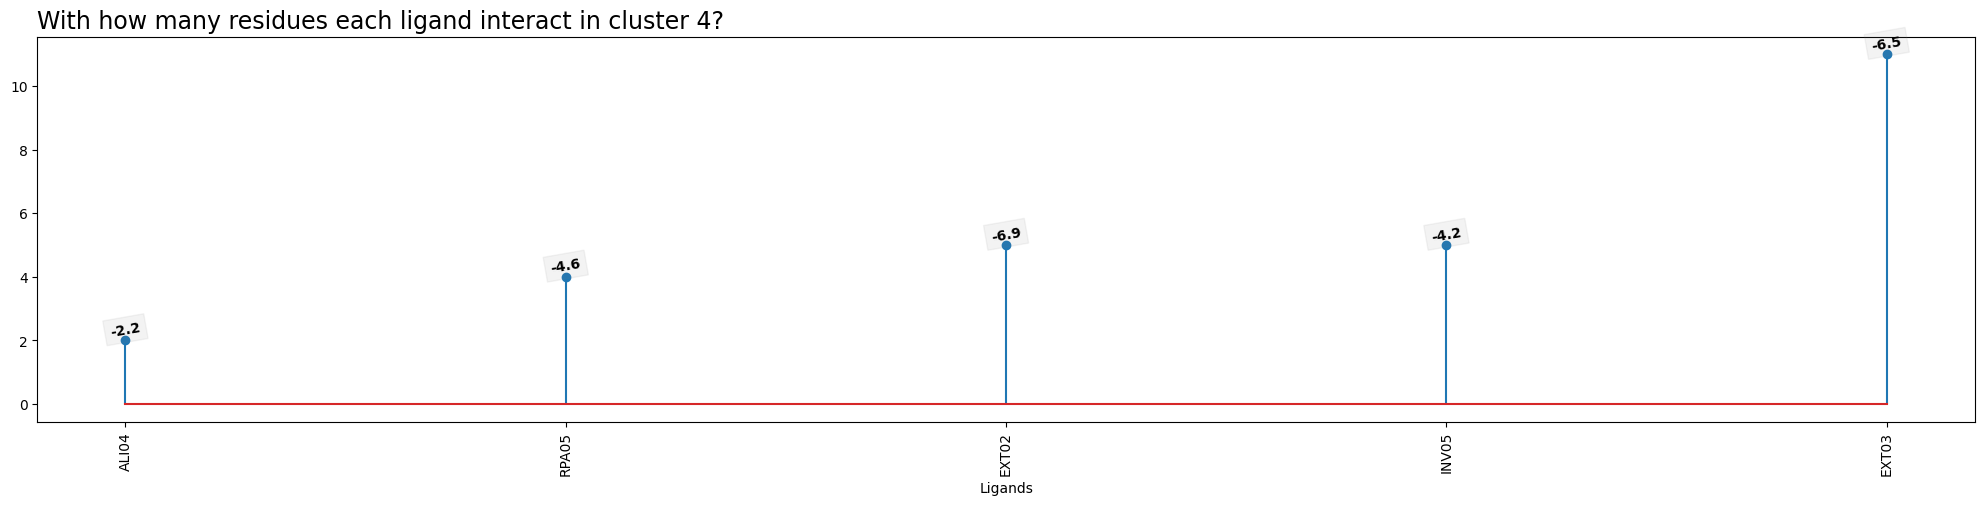

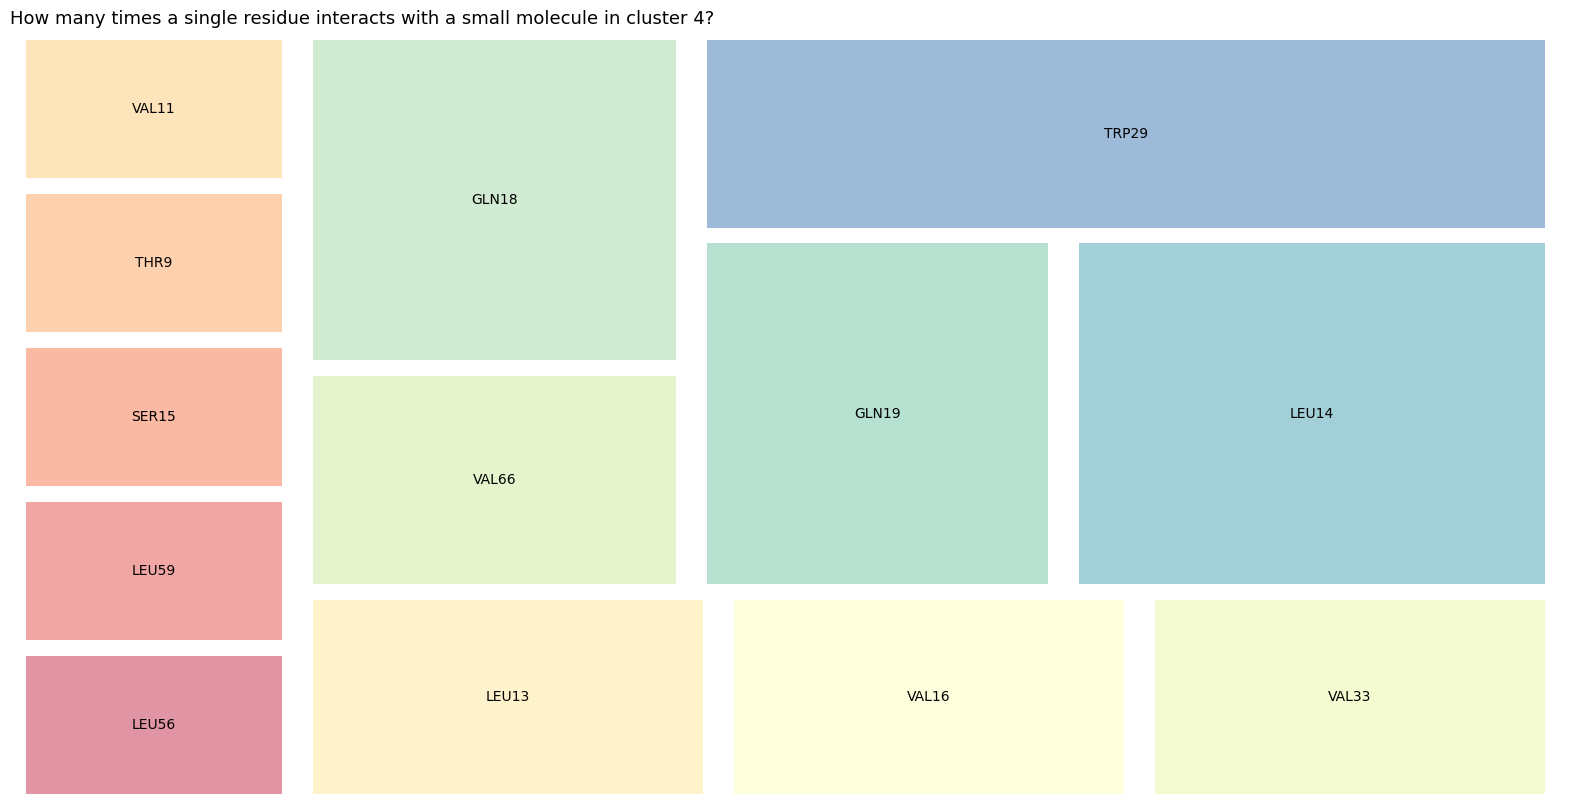

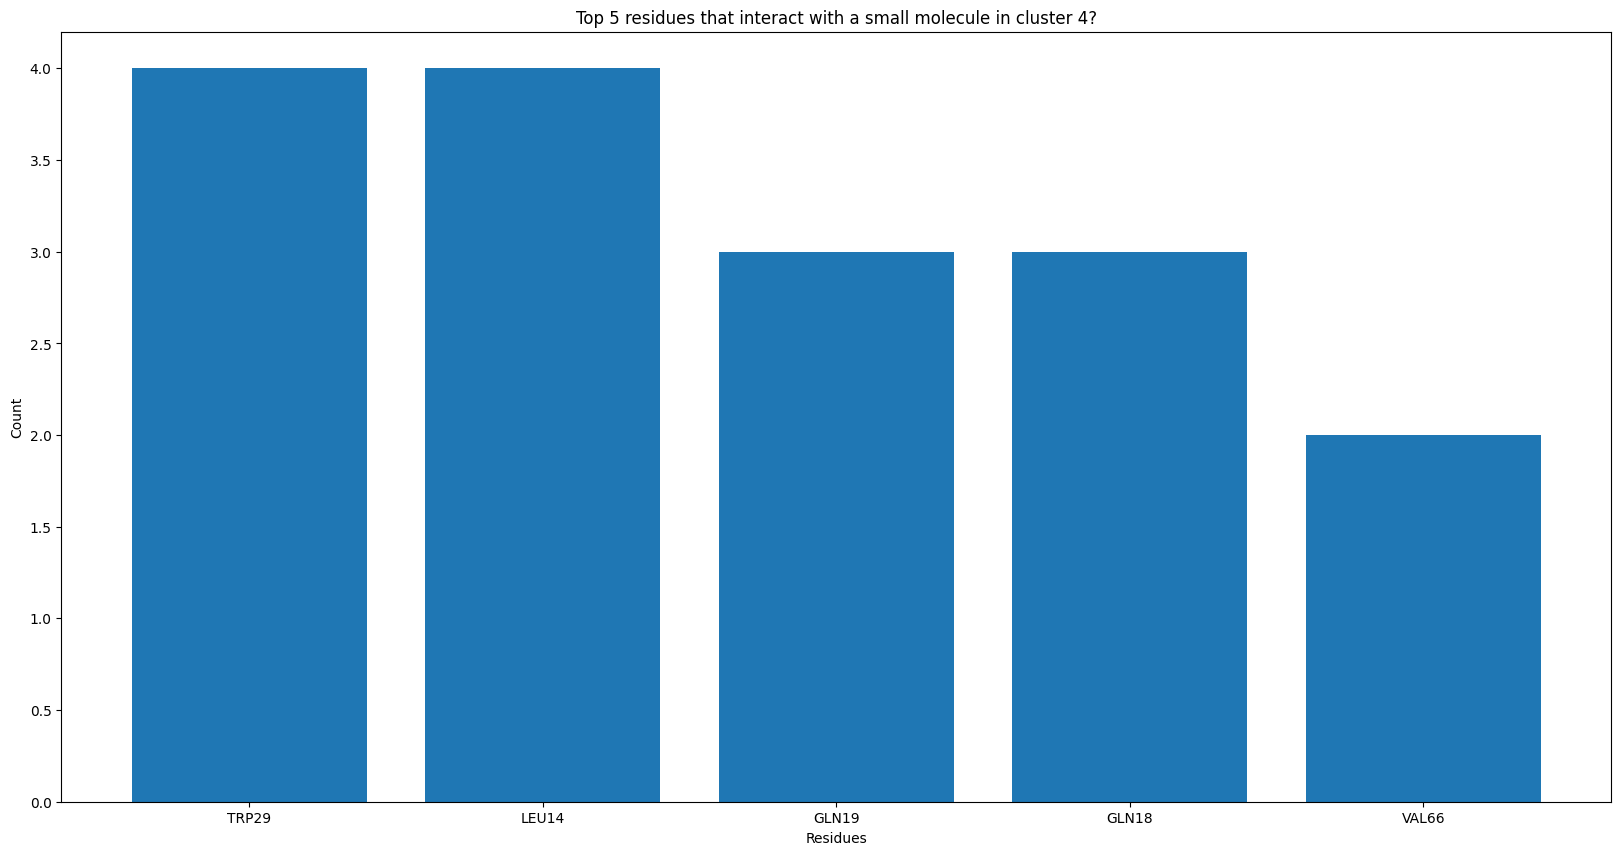

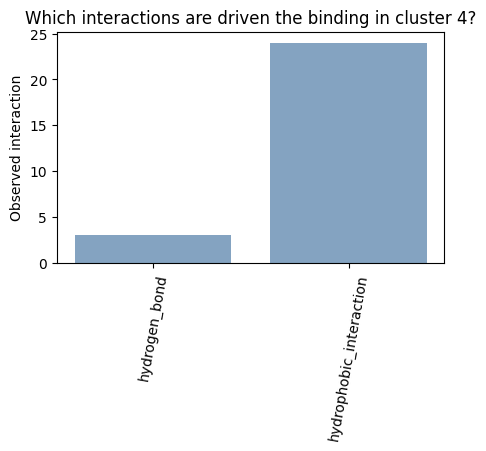

In [7]:
for c in range(n_clusters):
    dataset = eval(f"cluster_{c}")
    # Group by id 
    id = dataset.groupby(['id']).count()
    lig_interaction = id.reset_index()
    # Order the data | min to max
    lig_interaction_ord = lig_interaction.sort_values(by='resid')
    my_range=range(1,len(lig_interaction.index)+1)
    ## Group by resid
    resid = dataset.groupby(['resid']).count()
    res_interaction = resid.reset_index()
    # Order the data | min to max
    res_interaction_ord = res_interaction.sort_values(by='id')

    # Group by interaction
    interaction_type = dataset.groupby(['interaction']).count()
    interaction_type = interaction_type.reset_index()

    ## Count elements in clusters
    print(f"cluster_{c}" + " has " + str(dfs[c]['id'].nunique()) + " elements ")
 
    ## plot 1 | with how many residues each ligand interact?
    plt.rcParams["figure.figsize"] = [25,5]
    # Reorder it based on the values
    plt.stem(lig_interaction_ord['id'], lig_interaction_ord['resid'])
    plt.xticks(lig_interaction_ord['id'], rotation='vertical')
    plt.title(f"With how many residues each ligand interact in cluster {c}?", fontsize=17, loc="left")
    plt.xlabel("Ligands")
    ## plot 1 | add free energy of binding estimations
    values = dataset.groupby(['id'])[str(prot)].apply(lambda x: x.unique()[0]).to_dict()
    for i, ligand in enumerate(values):
        score = values[ligand]
        plt.annotate(score, (lig_interaction_ord['id'][i], lig_interaction_ord['resid'][i]),
                 textcoords="offset points",
                 xytext=(0,3),
                 ha='center',
                 rotation=10,
                 fontweight='bold',
                 bbox=dict(facecolor='grey', edgecolor='grey', alpha=0.09))
 
    plt.savefig(f'images/str(prot)/cluster_{c}_plot1.jpg', format='jpg')
    plt.show()


    ## plot 2 | with how many times a single residue interacts with a small molecule?
    plt.rcParams["figure.figsize"] = [20,10]
    axis = squarify.plot(sizes=res_interaction_ord['id'], label=res_interaction_ord['resid'], pad=1, alpha=.5,
                  color=sb.color_palette("Spectral", 
                                         len(res_interaction_ord)))
    plt.axis('off')
    axis.set_title(f"How many times a single residue interacts with a small molecule in cluster {c}?", loc="left", fontsize=13)
    plt.savefig(f'images/cluster_{c}_plot2.jpg', format='jpg')
    plt.show()
    plt.tight_layout()

    ## plot 3 | with how many times a single residue interacts with a small molecule?
    both = res_interaction_ord[::-1].head(5)
    plt.bar(both['resid'], both['id'])
    plt.rcParams["figure.figsize"] = [2,2]
    plt.title(f"Top 5 residues that interact with a small molecule in cluster {c}?")
    plt.xlabel("Residues")
    plt.ylabel("Count")
    plt.savefig(f'images/cluster_{c}_plot3.jpg', format='jpg')
    plt.show()


    ## plot 4 | Which interactions driven the binding?
    height = interaction_type['resid']
    bars = interaction_type['interaction']
    plt.rcParams["figure.figsize"] = [5,3]
    # create a dataset
    x_pos = np.arange(len(bars))
    # Create bars
    plt.bar(x_pos, height, color=(0.2, 0.4, 0.6, 0.6))
    # Create names on the x-axis
    plt.xticks(x_pos, bars, rotation=80)
    # Add title and axis names
    plt.title(f'Which interactions are driven the binding in cluster {c}?')
    plt.ylabel('Observed interaction')
    # Show graph
    plt.savefig(f'images/cluster_{c}_plot4.jpg', format='jpg')
    plt.show()

